# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

--2021-12-10 19:54:51--  https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638741 (624K) [image/png]
Saving to: ‘crossing.png.3’

crossing.png.3      100%[===================>] 623.77K  1.90MB/s    in 0.3s    

2021-12-10 19:54:52 (1.90 MB/s) - ‘crossing.png.3’ saved [638741/638741]



(800, 586)

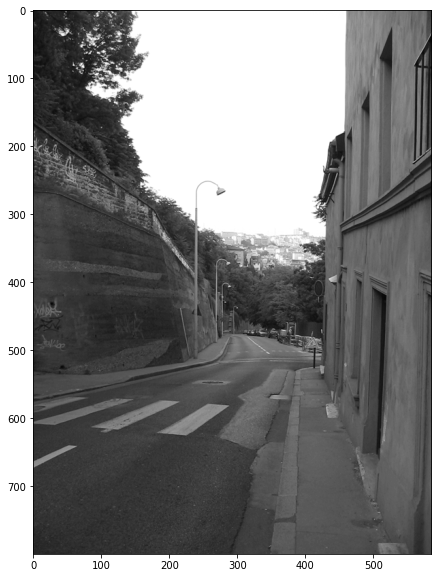

In [33]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small: 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \: \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [34]:
def segmentation_otsu(img):
    # TO FILL IN
    # RETURN BOTH THE SEGMENTED IMAGE AND THE THRESHOLD WHICH YOU HAVE FOUND
    tau_out = 0
    Steps = 1/255
    img_out = np.zeros(img.shape)
    min = np.inf
    for tau in np.arange(0,1,Steps):
        σ_0 = np.var(img[img<=tau])
        σ_1 = np.var(img[img>tau])
        crit = np.sum(img<=tau)*σ_0 + np.sum(img>tau)*σ_1 
        if crit < min:
            min = crit
            tau_out = tau
    img_out = (img>tau_out).astype(int)
    return img_out,tau_out

Carry out the segmentation on the input image and display the result

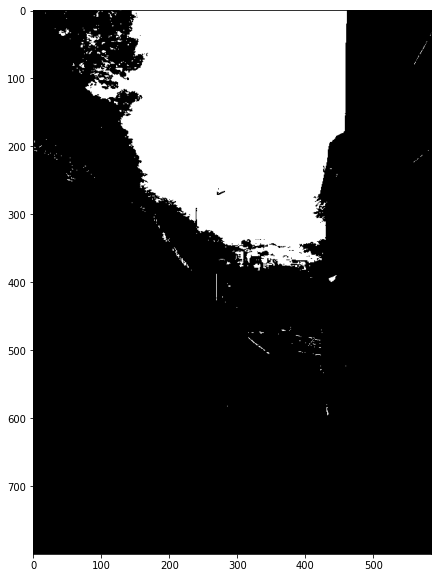

In [35]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

In [36]:
tau

0.6392156862745098

__Question 1.1__ What problem can you see with the segmentation result ? What technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__ :  As we notice from the  output image there are some small noise mainly inside the black region. Also inside the black region  there is no connection between the segmented object because of the global threshold.  also we could observe that the transition between dark and white region looks not to be smooth and there is no notion of geometric coherance. In order to clean the result we could use the opening and closing techniques, as the combination of Opening and Closing is generally used to clean up artifacts in the segmented image before using the image for digital analysis.

Carry this out on the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

__Question 1.2__ In which order should you carry out the operations (you can test the different possibilities) ? Why ?

__Answer__ We should notice that the opening operation can remove the object’s random noise while also maintaining the original shape. As we want to remove white points from black regions so we do an opening and after we do a closing to filling in small holes.


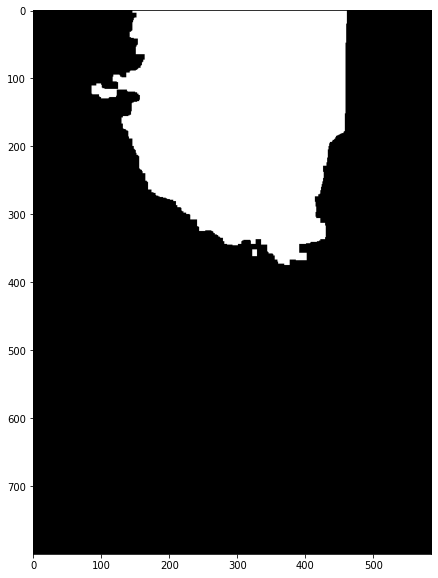

In [37]:
# FILL IN HERE
from skimage.morphology import opening, closing,square
img_out_otsu_cleaned = closing(opening(img_out_otsu,square(7)),square(7)) # FILL IN HERE


display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

Let's change the image, and carry out the segmentation again.

--2021-12-10 19:54:55--  https://perso.telecom-paristech.fr/anewson/doc/images/town.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 806256 (787K) [image/png]
Saving to: ‘town.png.3’

town.png.3          100%[===================>] 787.36K  2.39MB/s    in 0.3s    

2021-12-10 19:54:56 (2.39 MB/s) - ‘town.png.3’ saved [806256/806256]



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


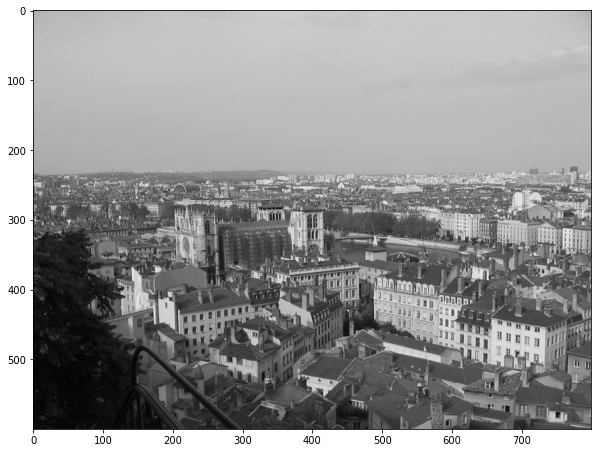

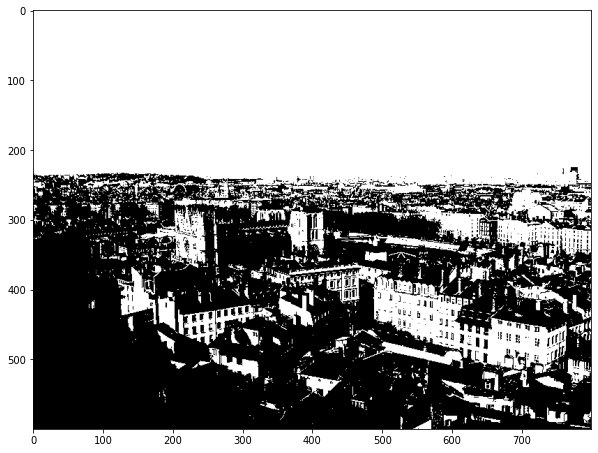

In [38]:
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [39]:
from scipy.ndimage.morphology import distance_transform_edt
def initialize_segmentation(seed_pt,img_shape):
    # FILL IN HERE
    seg_init = np.ones(img_shape)
    seg_init[seed_pt[0],seed_pt[1]] = 0
    seg_init = (distance_transform_edt(seg_init) < 7).astype(int)
    return seg_init

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

You will have to choose a neighbourhood that indicates which neighbouring pixels we want to try and include in the region. Use the following neighbourhood: $$ \begin{pmatrix} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0\end{pmatrix}$$

In [40]:
from scipy.ndimage.morphology import binary_dilation
def segmentation_region_growing(img,seed_pt,tau):
    # FILL IN HERE
    # RETURN BOTH THE SEGMENTED IMAGE AND THE INITIALISATION WHICH YOU FOUND
    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n = seg_init
    new_point = 1
    while new_point>0:
        average = np.sum(seg_n*img)/np.sum(seg_n)
        new_seg = binary_dilation(seg_n, mask = (np.abs(img-average)<tau))
        seg_n, new_point = new_seg, np.sum(new_seg) - np.sum(seg_n)  

    return seg_n,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

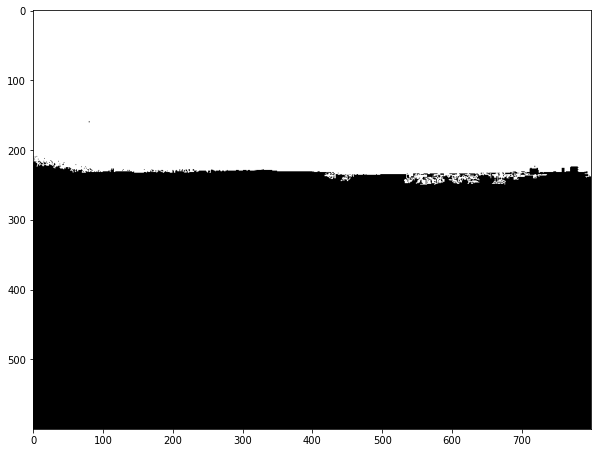

In [41]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

__Question 1.3__ What final problem, especially concering the boundary between the regions, can you see ? What method could be used instead of region growing, could solve this problem ?

__Answer__ We could remark that there is no notion of smoothness in the segment boundary. Hence, instead of region growing we turn to geometry-based approaches.where the best known is active contours (also known as the snakes model).